In [1]:
import os
import numpy as np

def load_all_updates(data_dirs):
    updates = []
    for run_dir in data_dirs:
        run_dir = "./dagmm_train_data/" + run_dir
        for fname in os.listdir(run_dir):
            if fname.endswith(".npy"):
                path = os.path.join(run_dir, fname)
                update = np.load(path)
                updates.append(update)
    return np.stack(updates)

def standardize(data, mean, std):
    return data #(data - mean) / (std + 1e-8)  # Add a small epsilon for numerical stability

dataset = "mnist"
train_dirs = [dataset + "/run_" + str(x) for x in range(1,15)]
train_unstandardized = load_all_updates(train_dirs)
mean = np.mean(train_unstandardized, axis=0)
std = np.std(train_unstandardized, axis=0)
#print(f"Standardizing with mean:{mean} and std:{std}")

X = standardize(train_unstandardized, mean, std) # Standardize the model updates

test_dir = [dataset + "/run_test_" + str(x) for x in range(1,3)]
VAL = standardize(load_all_updates(test_dir), mean, std)

X_train = X
X_test = VAL

print("Training samples:\n", X_train[0], '\n', X_train[1000], '\n', X_train[-1])
print("\nTest samples:\n", X_test[0], '\n', X_test[1000], '\n', X_test[-1])

input_dim = X_train.shape[1]
print("Input dim: ", input_dim)
print("Number of training data: ", len(X_train))
print("Number of validation data: ", len(X_test))

import torch
from torch.utils.data import TensorDataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1024

train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32)),
                              batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32)),
                              batch_size=batch_size, shuffle=False)

Training samples:
 [-0.1542326   0.02852689  0.1844252  ... -0.0286619   0.05342649
 -0.0031181 ] 
 [-0.05867351  0.17474414  0.20249419 ...  0.05445097  0.02090178
  0.03732899] 
 [ 0.07795206 -0.01389939  0.03749248 ...  0.04813148 -0.00778339
 -0.00448485]

Test samples:
 [-0.00510249 -0.16541158 -0.1996275  ... -0.03856351 -0.08525728
 -0.06713521] 
 [-0.13950148  0.16045414 -0.23551606 ... -0.01379922 -0.07255504
  0.01300576] 
 [-0.14041911  0.15433095 -0.24030511 ... -0.01202868 -0.07550421
  0.01654903]
Input dim:  61706
Number of training data:  8424
Number of validation data:  2200


Training
===

Looked first at these implementations:
* [github](https://github.com/danieltan07/dagmm/)
* [github](https://github.com/mperezcarrasco/PyTorch-DAGMM/blob/master)
* [github](https://gist.github.com/tam17aki/9671bc9af0e3f4e6338cf44e5e0a9a5b)

but was not successful.

Now mostly adapted from this [github](https://gist.github.com/tam17aki/9671bc9af0e3f4e6338cf44e5e0a9a5b) implementation.

In [17]:
def train_dagmm(model, train_loader, num_epochs, lr=1e-3, lambda_energy=0.1, lambda_cov=0.005, device='cuda', print_info=True):
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    i = 1
    for epoch in range(num_epochs):
        loss_info =  {
            "value": 0.0,
            "reconst": 0.0,
            "energy": 0.0,
            "cov_diag": 0.0,
        }

        for batch in train_loader:
            inputs = batch[0].to(device)
            optimizer.zero_grad()

            loss, loss_dict = model.compute_loss(inputs, lambda_energy, lambda_cov)
            
            # Update weights
            loss.backward()
            optimizer.step()

            # record objective function
            loss_info["value"] += loss.item()
            loss_info["reconst"] += loss_dict["reconst"]
            loss_info["energy"] += loss_dict["energy"]
            loss_info["cov_diag"] += loss_dict["cov_diag"]

        loss_epoch = loss_info["value"] / len(train_loader)
        reconst_epoch = loss_info["reconst"] / len(train_loader)
        energy_epoch = lambda_energy * loss_info["energy"] / len(train_loader)
        cov_epoch = lambda_cov * loss_info["cov_diag"]/ len(train_loader)

        if (i <= 5 or i % 10 == 0) and print_info:
            print(
                    f"Epoch {epoch + 1}/{num_epochs}: \t\t"
                    + f"loss={loss_epoch:.6f} \t\t"
                    + f"reconst={reconst_epoch:.6f} "
                    + f"energy={energy_epoch:.6f} "
                    + f"cov_diag={cov_epoch:.6f}"
                )
        i += 1    

In [7]:
def generate_random_samples(like_array, R=1e-3):
    return standardize(np.random.uniform(low=-R, high=R, size=like_array.shape), mean, std)

def generate_random_data(like_array, R_values):
    random_data = []
    for R_value in R_values:
        random_data.append(generate_random_samples(like_array, R_value))
    return random_data

# Generate random samples (same shape as test set)
random_data = generate_random_data(X_test, [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e1])
print("Random data used:")
for r in random_data:
    print(f"{r[0][:5]}")

Random data used:
[ 0.01386216 -0.03400982  0.07607369  0.05294937  0.09957233]
[ 0.00913583 -0.00905341 -0.00173386 -0.00893133 -0.00072243]
[ 2.41919893e-04 -6.14379438e-05 -3.23094549e-04  9.84131408e-04
  3.99529100e-04]
[ 2.22485783e-05  6.53308060e-05 -9.03271934e-05 -7.00866310e-05
  8.44658093e-05]
[ 6.65646562e-06 -4.36172813e-06 -3.58481397e-06  8.14096112e-06
  8.04451446e-06]
[ 4.17920992e-07 -4.58289021e-07  5.43995688e-09  1.90785764e-07
 -8.43470384e-07]
[-1.36442283 -1.51791687 -3.96489962  9.61316037 -2.37652092]


In [8]:
# Function to retrieve a list of energies of random data
def get_random_energies(random_data, dagmm_model, gmm_params):
    energy_list = []
    for data in random_data:
        data_loader = DataLoader(TensorDataset(torch.tensor(data, dtype=torch.float32)),
                                batch_size=batch_size, shuffle=False)
        energies = dagmm_model.compute_energies(data_loader, gmm_params)
        energy_list.append(energies)
    return energy_list

Hyperparameter Grid Search
---

In [18]:
from dagmm import DAGMM, DAGMM_Hyperparameters
# Fixed Model settings
dimensions = [input_dim, 256, 128, 64]
latent_dim = 16
estimation_hidden_size = 8

# Fixed Training settings
lambda_energy=0.1
lambda_cov=0.01

# 1. Set seed for PyTorch
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

epoch_params = [50]
n_gmm_params = [6]

print_info = True   # Whether or not to print the losses.

# Initialize with 0 - anything smaller will indicate no separation of test and random data.
best_score = 0
best_model = None
best_hyperparameters = None
best_gmm_params = None

for epoch_p in epoch_params:
    for n_gmm_p in n_gmm_params:
        parameters = {
            "epoch": epoch_p,
            "n_gmm": n_gmm_p
        }
        print(f"Using parameters:\t epoch={epoch_p}, n_gmm={n_gmm_p}")

        # Generate DAGMM_Hyperparameters
        hyperparameters = DAGMM_Hyperparameters(dimensions, latent_dim, estimation_hidden_size, n_gmm_p)

        # --- Train the model ---
        dagmm_model = DAGMM(device, hyperparameters)
        train_dagmm(dagmm_model, train_loader, epoch_p, lambda_energy=lambda_energy, lambda_cov=lambda_cov, print_info=print_info)

        # Obtain gmm parameters
        gmm_params = dagmm_model.compute_gmm_params(train_loader)
        
        # --- Evaluate the model ---
        train_energies = dagmm_model.compute_energies(train_loader, gmm_params)
        test_energies = dagmm_model.compute_energies(test_loader, gmm_params)
        mean_train_energy = np.mean(train_energies)
        mean_test_energy = np.mean(test_energies)

        random_energies_list = get_random_energies(random_data, dagmm_model, gmm_params)
        random_energies_lower_percentiles = []
        for random_energies in random_energies_list:
            # Get the 20th percentile of the random energies.
            random_energies_lower_percentiles.append(np.percentile(random_energies, 20))

        # Objective function of the grid search
        train_test_diff = np.abs(mean_train_energy - mean_test_energy)
        random_test_diffs = []
        for random_percentile in random_energies_lower_percentiles:
            random_test_diffs.append(random_percentile - mean_test_energy)

        # Use the percentile with the smallest energy. If this is higher than the mean energy of the test data, it is separable.
        min_rand_test_diff = np.min(random_test_diffs)
        
        # The difference between training and test data should be small (not that important, thus we ommit it)
        # and the energy value (lower x'th percentile) of the (closest) random data should be bigger than the mean energy of the test data (very important to be able to separate)
        # A negative score indicates that the random data could not be separated well from the test data.
        # A positive score indicates that the separation works (the higher the score, the better the separation!)
        score = min_rand_test_diff  # - 0.1*train_test_diff
        print(f"Obtained score: {score}")

        if score > best_score:
            best_score = score
            best_model = dagmm_model
            best_hyperparameters = hyperparameters
            best_gmm_params = gmm_params
            print(f"\t\t!!! New best model found !!!")

Using parameters:	 epoch=50, n_gmm=6
Epoch 1/50: 		loss=39869.735604 		reconst=0.008892 energy=1.303929 cov_diag=39868.422783
Epoch 2/50: 		loss=346.785151 		reconst=0.019742 energy=1.352900 cov_diag=345.412509
Epoch 3/50: 		loss=169.324068 		reconst=0.026218 energy=1.361137 cov_diag=167.936712
Epoch 4/50: 		loss=148.480258 		reconst=0.029590 energy=1.365414 cov_diag=147.085254
Epoch 5/50: 		loss=134.091279 		reconst=0.031174 energy=1.366895 cov_diag=132.693209
Epoch 10/50: 		loss=98.850038 		reconst=0.032578 energy=1.369935 cov_diag=97.447525
Epoch 20/50: 		loss=65.601780 		reconst=0.033190 energy=1.367337 cov_diag=64.201253
Epoch 30/50: 		loss=49.345093 		reconst=0.033744 energy=1.361531 cov_diag=47.949819
Epoch 40/50: 		loss=40.433142 		reconst=0.034151 energy=1.352368 cov_diag=39.046623
Epoch 50/50: 		loss=34.686976 		reconst=0.034351 energy=1.346767 cov_diag=33.305858
Obtained score: 3.4484171083103305
		!!! New best model found !!!


In [19]:
# Save everything
torch.save(best_model.state_dict(), "dagmm_model_mnist.pt")

for name, gmm_param in best_gmm_params.items():
    gmm_name = "gmm_param_" + name + ".pt"
    torch.save(gmm_param, gmm_name)

# Store hyperparameters as a .yaml file
best_hyperparameters.save_params("./dagmm_hyperparameters.yaml")

Testing
===

In [20]:
from dagmm import DAGMM, DAGMM_Hyperparameters
import torch
hyperparameters = DAGMM_Hyperparameters.load_params("./dagmm_hyperparameters.yaml")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from dagmm import DAGMM
dagmm_model = DAGMM(device, hyperparameters)
dagmm_model.load_state_dict(torch.load("./dagmm_model_mnist.pt", map_location=device))
dagmm_model.to(device)

DAGMM(
  (encoder): Sequential(
    (0): Linear(in_features=61706, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=128, bias=True)
    (2): Tanh()
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): Tanh()
    (5): Linear(in_features=256, out_features=61706, bias=True)
  )
  (estimation): Sequential(
    (0): Linear(in_features=18, out_features=8, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=8, out_features=6, bias=True)
    (4): Softmax(dim=1)
  )
)

In [21]:
gmm_params = {}
gmm_params["mixture"] = torch.load("gmm_param_mixture.pt")
gmm_params["mean"] = torch.load("gmm_param_mean.pt")
gmm_params["cov"] = torch.load("gmm_param_cov.pt")

In [22]:
train_energies = dagmm_model.compute_energies(train_loader, gmm_params)
test_energies = dagmm_model.compute_energies(test_loader, gmm_params)
print("Mean of train energies: ", np.mean(train_energies))
print("Mean of test energies: ", np.mean(test_energies))

Mean of train energies:  19.9361106041293
Mean of test energies:  29.30592900239654


In [23]:
random_energies = get_random_energies(random_data, dagmm_model, gmm_params)

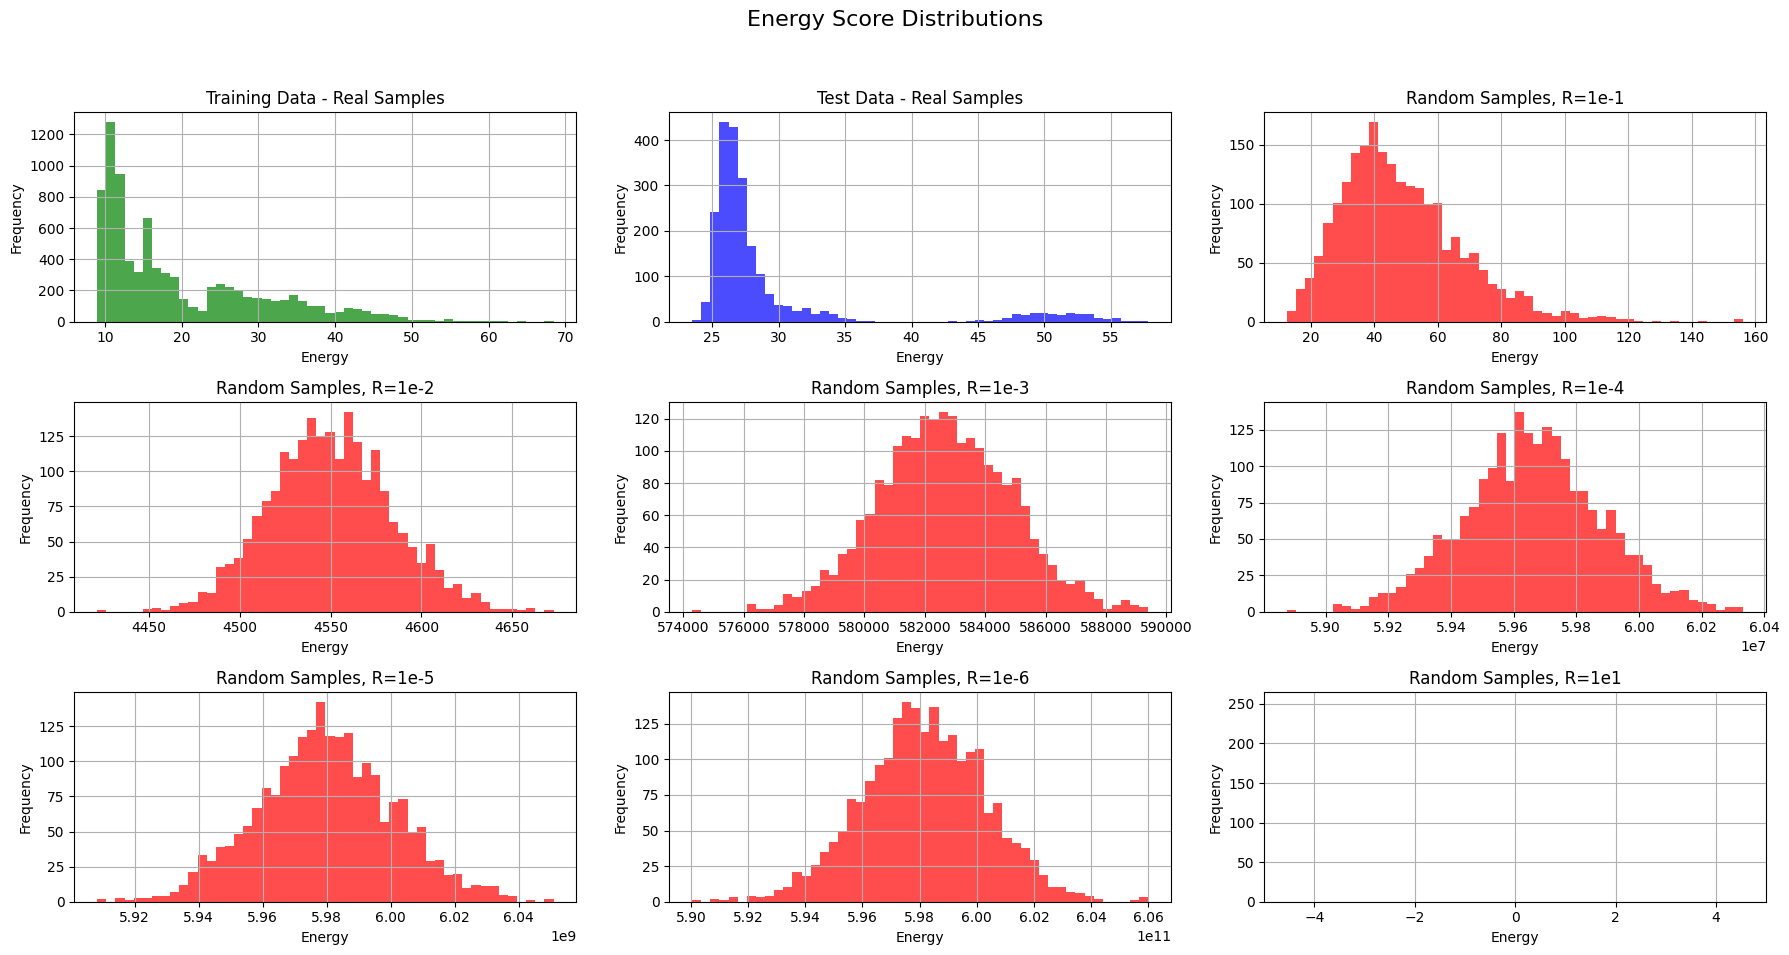

In [24]:
import matplotlib.pyplot as plt
# Plotting
# Plotting separate histograms
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
fig.suptitle("Energy Score Distributions", fontsize=16)

# Plot 1: 
axes[0, 0].hist(train_energies, bins=50, alpha=0.7, color='green')
axes[0, 0].set_title("Training Data - Real Samples")
axes[0, 0].set_xlabel("Energy")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].grid(True)

# Plot 2: 
axes[0, 1].hist(test_energies, bins=50, alpha=0.7, color='blue')
axes[0, 1].set_title("Test Data - Real Samples")
axes[0, 1].set_xlabel("Energy")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].grid(True)

# Plot 3: 
axes[0, 2].hist(random_energies[0], bins=50, alpha=0.7, color='red')
axes[0, 2].set_title("Random Samples, R=1e-1")
axes[0, 2].set_xlabel("Energy")
axes[0, 2].set_ylabel("Frequency")
axes[0, 2].grid(True)

# Plot 4: 
axes[1, 0].hist(random_energies[1], bins=50, alpha=0.7, color='red')
axes[1, 0].set_title("Random Samples, R=1e-2")
axes[1, 0].set_xlabel("Energy")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].grid(True)

# Plot 5: 
axes[1, 1].hist(random_energies[2], bins=50, alpha=0.7, color='red')
axes[1, 1].set_title("Random Samples, R=1e-3")
axes[1, 1].set_xlabel("Energy")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].grid(True)

# Plot 6: 
axes[1, 2].hist(random_energies[3], bins=50, alpha=0.7, color='red')
axes[1, 2].set_title("Random Samples, R=1e-4")
axes[1, 2].set_xlabel("Energy")
axes[1, 2].set_ylabel("Frequency")
axes[1, 2].grid(True)

# Plot 7: 
axes[2, 0].hist(random_energies[4], bins=50, alpha=0.7, color='red')
axes[2, 0].set_title("Random Samples, R=1e-5")
axes[2, 0].set_xlabel("Energy")
axes[2, 0].set_ylabel("Frequency")
axes[2, 0].grid(True)

# Plot 8: 
axes[2, 1].hist(random_energies[5], bins=50, alpha=0.7, color='red')
axes[2, 1].set_title("Random Samples, R=1e-6")
axes[2, 1].set_xlabel("Energy")
axes[2, 1].set_ylabel("Frequency")
axes[2, 1].grid(True)

# Plot 9: 
axes[2, 2].hist(random_energies[6], bins=50, alpha=0.7, color='red')
axes[2, 2].set_title("Random Samples, R=1e1")
axes[2, 2].set_xlabel("Energy")
axes[2, 2].set_ylabel("Frequency")
axes[2, 2].grid(True)
axes[2, 2].set_xlim(-5, 5) # Adjust based on data

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

In [25]:
percentile = 90
threshold_percentile = np.percentile(test_energies, percentile)
print(f"{percentile} percentile is: {threshold_percentile:.4f}")
factor = 1.0
threshold = threshold_percentile * factor

print(f"\nAnomaly Threshold (at {factor} * {percentile}th percentile of all energies): {threshold:.4f}")
print("Maximum energy: ", max(test_energies))

90 percentile is: 34.3152

Anomaly Threshold (at 1.0 * 90th percentile of all energies): 34.3152
Maximum energy:  57.82654115651928


In [26]:
import yaml
threshold_dict = {
    'dagmm_threshold': float(threshold)
}

output_yaml_path = 'dagmm_anomaly_threshold.yaml'
with open(output_yaml_path, 'w') as file:
    yaml.dump(threshold_dict, file, default_flow_style=False)

print(f"Anomaly threshold saved to '{output_yaml_path}'")

Anomaly threshold saved to 'dagmm_anomaly_threshold.yaml'


In [27]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

def get_z_values(dataloader, dagmm_model):
    z_values = []
    for batch in dataloader:
        inputs = batch[0].to(device)

        _, latents, _ = dagmm_model.forward(inputs)
        z_values.append(latents)
    return torch.cat(z_values, dim=0).detach().cpu().numpy()

def pca_with_random_data(real_loaders, real_lables, random_data_list, dagmm_model):
    z_values_real = []
    for loader in real_loaders:
        z_values_real.append(get_z_values(loader, dagmm_model))

    labels = []
    z_values_random_list = []
    for i, rand_data in enumerate(random_data_list):
        random_dataloader = DataLoader(TensorDataset(torch.tensor(rand_data, dtype=torch.float32)),
                                batch_size=batch_size, shuffle=False)
        z = get_z_values(random_dataloader, dagmm_model)
        z_values_random_list.append(z)
        labels.append(f"Random_{i+1}")

    # Use PCA for 2D projection
    pca = PCA(n_components=2)
    z_real_2d = [pca.fit_transform(data) for data in z_values_real]
    z_random_2d = [pca.transform(data) for data in z_values_random_list]

    plt.figure(figsize=(8, 6))
    for data_2d, label in zip(z_real_2d, real_lables):
        sns.scatterplot(x=data_2d[:,0], y=data_2d[:,1], label=label, alpha=0.6)

    for i, data_2d in enumerate(z_random_2d):
        sns.scatterplot(x=data_2d[:,0], y=data_2d[:,1], label=labels[i], alpha=0.6)

    plt.title("PCA of Latent z-space")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

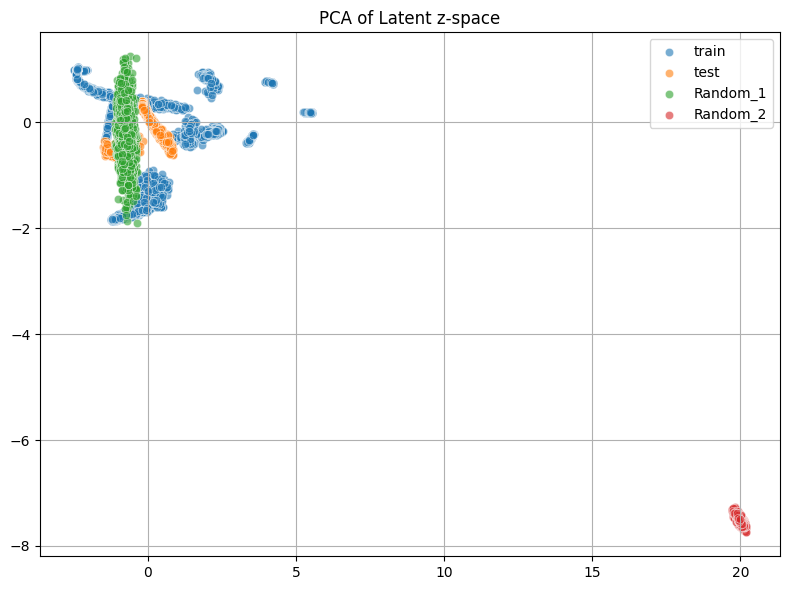

In [35]:
pca_with_random_data([train_loader, test_loader], ["train", "test"], random_data[:2], dagmm_model)

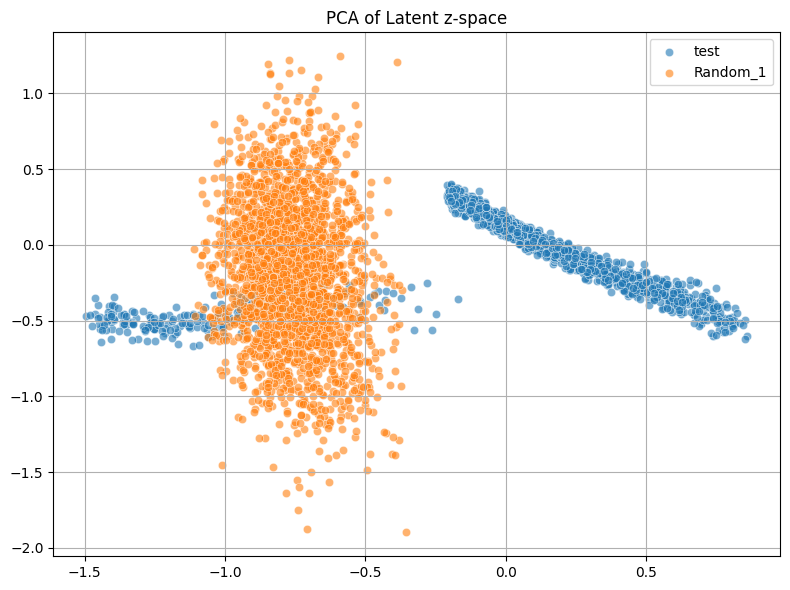

In [36]:
pca_with_random_data([test_loader], ["test"], [random_data[0]], dagmm_model)